C3030 population analysis
MJ Rose

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import Image, display
from IPython.display import HTML as html_print
import numpy as np
import os, glob, subprocess, time, psutil, sys, shutil, fnmatch
import pandas as pd
import pymultinest,os, threading, subprocess, time, math
import scipy.optimize as opt
import scipy.stats as stats
import scipy.special as special # For access to the incomplete gamma function.
import emcee, corner
from collections import namedtuple
from collections import OrderedDict
from collections import Counter

# Joe's SED plotting 
import seds_plot_func

# my own
from reduction_funcs import *

    

# set save path
image_dir = "/Users/mmcintosh/Dropbox/ASTRON2017/C3030/population_plots/"
if not os.path.exists(image_dir):
	os.makedirs(image_dir)
 
model_ev_dir = '/Users/mmcintosh/Dropbox/ASTRON2017/C3030/model_ev/'
# read in data
sed_df = pd.read_pickle(model_ev_dir+'modeled_df.pkl')



In [77]:
import collections
import gpscssmodels
def get_argnames(func):
    return(func.__code__.co_varnames[:func.__code__.co_argcount][1:])

Model = collections.namedtuple('Model', 'name args fit mechanism')

shapedict = {'SSA':'o', 'FFA': '^', 'Neither': '*'}
mechdict = {'singSSA':'SSA',
 'doubSSA':'SSA',
 'singinhomobremss':"FFA",
 'singinhomobremssbreak':"FFA",
 'singinhomobremssbreakexp':"FFA",
 'doubhomobremss':'FFA',
 'doubSSAbreakexp':'SSA',
 'curve': 'Neither'}
cdict_models = {'singhomobremss':'red',
        'singinhomobremssbreakexp':'maroon',
        'singinhomobremssbreak': 'orangered',
        'singinhomobremss':'darkturquoise',
        'singinhomobremsscurve':'#4682b4',
        'doubhomobremss':'saddlebrown',
        'doubhomobremss':'Chocolate',
        'doubhomobremssbreak':'olive',
        'doubhomobremssbreak':'DarkGoldenRod',
        'singSSA':'orchid',
        'singSSAcurve':'darkmagenta',
        'singSSAbreak':'indigo',
        'doubSSA':'navy',
        'doubSSAbreakexp':'MediumSeaGreen',
        'doubSSAbreak':'black',
        'powlaw': 'DarkOrange',
        'powlawbreak':'dogerblue',
        'internalbremss':'sienna',
        'curve':'k'
            } 

cdict_mech = {'SSA':'orchid',
 'FFA':'MediumSeaGreen',
 'Neither':'indigo'}

latex_dict = {'curve': 'General', 'singSSA': 'Single SSA', 'doubSSA': 'Double SSA', 'singinhomobremss':'Single Inhomogeneous FFA',
              'singinhomobremssbreak':'Single Inhomogeneous FFA + break', 'singinhomobremssbreakexp':'Single Inhomogeneous FFA + exp. break',
              'doubhomobremss':'Double Homogeneous FFA','doubSSAbreakexp':'Double SSA + exp. break'}

In [6]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['serif'],'size':16})

In [164]:
# set up to loop over sources
iterlist_all = sed_df.index.tolist()

# select those with ATCA data
uvfmeas_paths = []
for p in ["/Volumes/mjrose/C3030/"]:
    path = p
    regex = 'uvfmeaslog*'
    uvfmeas_paths.extend(recursive_glob(path, regex))

missing_uv = []
for i in sed_df.index.tolist():
    name = sed_df.loc[i]['name']
    if not isinstance(name, str):
        name = name[0]

    path = [s for s in uvfmeas_paths if name in s]
    if path == []:
        path = [s for s in uvfmeas_paths if name.split('pks')[-1] in s]
    if path == []:
        path = [s for s in uvfmeas_paths if name.split('mwacsj')[-1] in s]
    if path == []:
        path = [s for s in uvfmeas_paths if name.split('mwacsj')[-1].split('-')[0] in s]
    if path == []:
        missing_uv.append(i)
        
iterlist_ATCAonly = [i for i in iterlist_all if i not in missing_uv]

In [224]:
strong_evidence = []
moderate_evidence = []
weak_evidence = []
no_evidence = []
first_df = pd.DataFrame(index=iterlist_ATCAonly, columns=['name','model','peak', 'freq', 'mechanism', 'thin', 'thick', 'z', 'ls', 'power'])
second_df  = pd.DataFrame(index=iterlist_ATCAonly, columns=['name','model','peak', 'freq', 'mechanism'])
for i in iterlist_ATCAonly:
    name = sed_df.loc[i]['name']
    try:
        models = pd.read_pickle(model_ev_dir+name+'.pkl')
    except:
        pass
    # print out evidence
    mn_ev_arr = []
    for idx in models.index:
        mn_evidence = models.loc[idx].multinest['nested sampling global log-evidence'].values[0]
        mn_evidence_err = models.loc[idx].multinest['nested sampling global log-evidence error'].values[0]
        mn_ev_arr.append(mn_evidence - np.abs(mn_evidence_err))
        #print('multinest evidence for {0}: {1:.2f} +/- {2:.2f}'.format(idx,mn_evidence,mn_evidence_err))
    best_model = [models.index[x] for x in np.argsort(mn_ev_arr)[::-1]]
    vals = [mn_ev_arr[i] for i in np.argsort(mn_ev_arr)[::-1]]
    #print('best to worst models: {0}'.format(best_model))
    
    # just to see
    indx = [i for i,s in enumerate(best_model) if 'singinhomobremssbreak' == s][0]
    del best_model[indx]
    del vals[indx]
    
    first_df.set_value(i,'name', name)
    first_df.set_value(i,'model', best_model[0])
    
    second_df.set_value(i,'name', name)
    second_df.set_value(i,'model', best_model[1])

    dellnz = (vals[0] - vals)[1:]
    if all(i >= 3 for i in dellnz):
        strong_evidence.append(best_model[0])
    elif all(i >= 1 for i in dellnz):
        moderate_evidence.append(best_model[0])
    elif all(i >= 0 for i in dellnz):
        weak_evidence.append(best_model[0])
    else: 
        no_evidence.append(best_model[0])

# Histogram by Mechanism

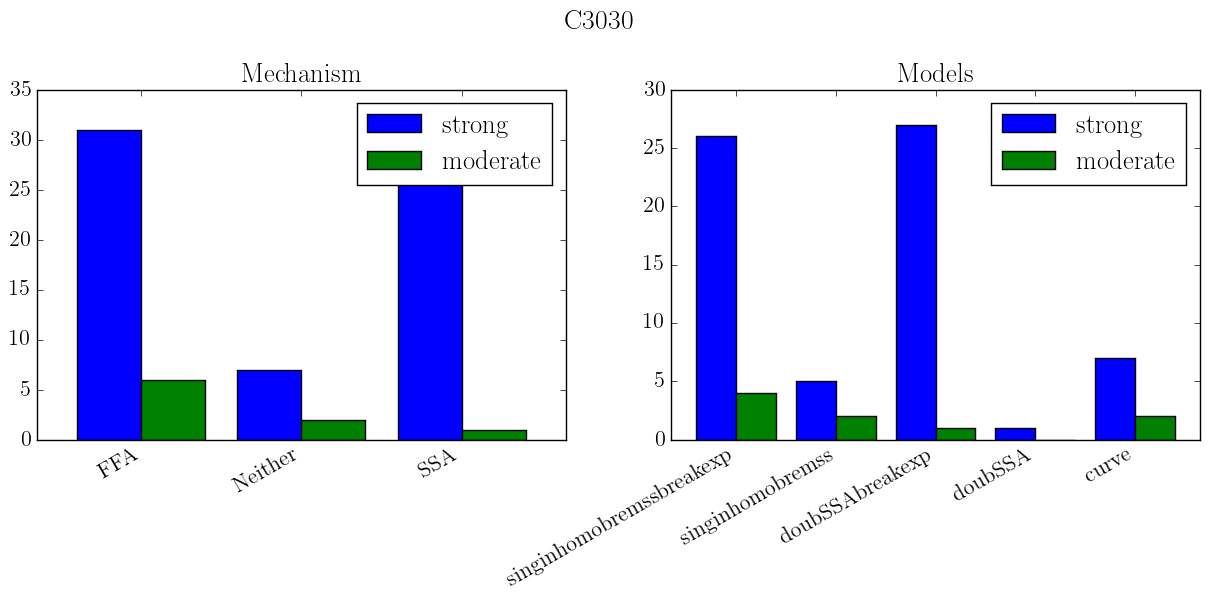

In [225]:
data = pd.DataFrame([Counter(strong_evidence),Counter(moderate_evidence)], index = ['strong', 'moderate'])
data = data.T
data['Mechanism'] = [mechdict[i] for i in data.index]

fig = plt.figure(1,figsize=(15, 10))
gs = plt.GridSpec(1,2, height_ratios = [1,1], hspace = 1)
ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
width = 0.8
data.groupby('Mechanism').sum().plot(kind='bar', width=width, ax=ax, title='Mechanism')
ax.set_xlabel("")
data.iloc[::-1].plot(kind='bar', width = width, ax=ax1, title="Models")
fig.suptitle('C3030', size=20)
fig.autofmt_xdate()

# Peak flux vs Peak Frequency

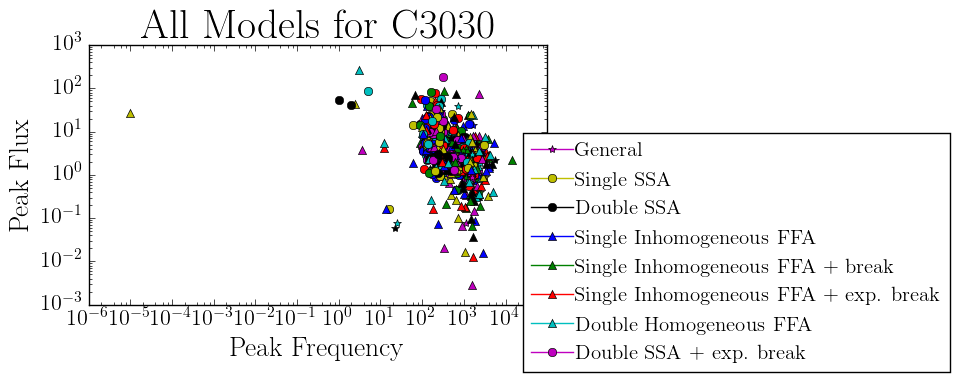

In [177]:
fig = plt.figure()
ax = plt.gca()
freq_arr = np.linspace(0,20e+3,20e+3)
for name in sed_df.loc[iterlist_ATCAonly].name.values:
    try:
        models = pd.read_pickle(model_ev_dir+name+'.pkl')
    except:
        continue
        
    indx = first_df[first_df.name == name].index[0]
    fits = []
    mod = []
    for i in range(len(models)):
        fits.append(models.multinest[i].fit[0])
        mod.append(models.index[i])
    argnames = [get_argnames(getattr(gpscssmodels, m)) for m in mod]
    temp = [Model(name=m, args=arg, fit=f, mechanism=mechdict[m]) for m,arg,f in zip(mod, argnames, fits)]
    for i in range(len(temp)):        
        index = [ind for ind,s in enumerate(temp[i].args) if 'norm' in s]
        peaks = [temp[i].fit[ind] for ind in index]
        index = [ind for ind,s in enumerate(temp[i].args) if 'peak' in s]
        freqs = [temp[i].fit[ind] for ind in index]
        if len(peaks) > 1:
            peaks = np.nanmax(getattr(gpscssmodels, temp[i].name)(freq_arr,*temp[i].fit))
            freqs = freq_arr[np.nanargmax(getattr(gpscssmodels, temp[i].name)(freq_arr,*temp[i].fit))]
        else:
            peaks = peaks[0]
            freqs = freqs[0]
        
        if temp[i].name == first_df.loc[indx].model:
            first_df.set_value(indx,'peak', peaks)
            first_df.set_value(indx,'freq', freqs)
            first_df.set_value(indx,'mechanism', temp[i].mechanism)
            if 'alpha' in temp[i].args:
                jndx = [j for j,x in enumerate(temp[i].args) if 'alpha' in x]
                thin = temp[i].fit[jndx[0]]
                first_df.set_value(indx,'thin', thin)
                pndx = [j for j,x in enumerate(temp[i].args) if 'p' in x]
                if len(pndx) >=1:
                    p = temp[i].fit[pndx[0]]
                    thick = thin - 2.1*(p + 1)
                    first_df.set_value(indx,'thick', thick)
                    
                        
                               
        if temp[i].name == second_df.loc[indx].model:
            second_df.set_value(indx,'peak', peaks)
            second_df.set_value(indx,'freq', freqs)
            second_df.set_value(indx,'mechanism', temp[i].mechanism)
        ax.plot(freqs, peaks, marker=shapedict[temp[i].mechanism], c=cdict_models[temp[i].name], label = latex_dict[temp[i].name])
    
ax.set_yscale('log')
ax.set_xscale('log')    
plt.ylabel('Peak Flux', size = 20)
plt.xlabel('Peak Frequency', size = 20)
plt.title('All Models for C3030', size = 30)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
bbox = (1.9,0.7)
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=bbox, fontsize=15,handletextpad=0.1,numpoints=1)
fig.tight_layout()
plt.show()

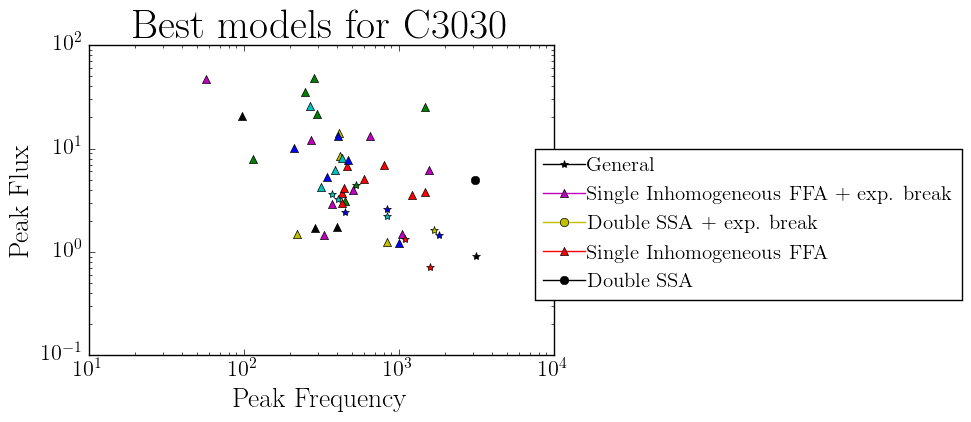

In [172]:
fig = plt.figure()
ax = plt.gca()

for i in first_df.index.values:
    try:
        ax.plot(first_df.loc[i].freq, first_df.loc[i].peak, marker=shapedict[first_df.loc[i].mechanism], c=cdict_models[first_df.loc[i].model], label = latex_dict[first_df.loc[i].model])
    except:
        pass
        #print(first_df.loc[i])
ax.set_yscale('log')
ax.set_xscale('log')    
plt.ylabel('Peak Flux', size = 20)
plt.xlabel('Peak Frequency', size = 20)
plt.title('Best models for C3030', size = 30)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
bbox = (1.9,0.7)
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=bbox, fontsize=15,handletextpad=0.1, numpoints=1)
#fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.gca()

for i in first_df.index.values:
    try:
        ax.scatter(second_df.loc[i].freq, second_df.loc[i].peak, marker=shapedict[second_df.loc[i].mechanism], c=cdict_models[second_df.loc[i].model], label = latex_dict[second_df.loc[i].model])
    except:
        pass
        #print(second_df.loc[i])
ax.set_yscale('log')
ax.set_xscale('log')    
plt.ylabel('Peak Flux', size = 20)
plt.xlabel('Peak Frequency', size = 20)
plt.title('Second best models for C3030', size = 30)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
bbox = (1.9,0.7)
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=bbox, fontsize=15,handletextpad=0.1)
#fig.tight_layout()
plt.show()

In [ ]:
first_df.to_csv('../survey_data/first.csv')

In [ ]:
import glob
jay_df = pd.DataFrame()
# S. Jeyakumar 2016 paper
texfiles = glob.glob('../survey_data/*.tex')
jey = []
for tex in texfiles: 
    try:
        tempdf = pd.read_csv(tex,
                         sep='&',
                         header=None,
                         engine='python', names = ['Source', 'Sample',  'ID', 'z', 'LAS', 'Vpeakc', 'Speak', 'LS', 'log(Lpeak)', 'Refd'])
        jay_df = tempdf.append(tempdf, ignore_index = True)
    except:
        print(tex)

jaynames = [''.join(name.lower().strip().split('$')) for name in jay_df.Source.values]
ra = []
dec = []
n=2
for j in jaynames:
    split =re.split(r'(\d+)', j)
    line = split[1]
    ra.append(':'.join([line[i:i+n] for i in range(0, len(line), n)])+':00')
    line = split[3]
    dec.append(split[2]+':'.join([line[i:i+n] for i in range(0, len(line), n)])+':00')
jay_df['RA'] = ra
jay_df['DEC'] = dec

jay_df.to_csv('../survey_data/jey.csv')
first_df.to_csv('../survey_data/first.csv')

In [ ]:
# grom gleam_and_friends.csv, for matching with jey and first
full_df = pd.read_csv('../survey_data/full.csv')
full_df.ID = [''.join(name.lower().strip().split('$')) for name in full_df.ID.values]
full_df.to_csv('../survey_data/full.csv')

In [ ]:
temp

In [ ]:
len(jay_df), len(ra)

In [23]:
# switched to topcat to match jey, first, and gleam
matched_df = pd.read_csv('../survey_data/jay_match.csv')

In [ ]:
plt.scatter(matched_df.freq,matched_df.LS_1)
plt.xlabel('Frequency')
plt.ylabel('Linear Size (kpc)')
plt.show()
plt.scatter(matched_df.freq,matched_df.z_1)
plt.xlabel('Frequency')
plt.ylabel('Redshift')
plt.show()

In [178]:
first_df.to_csv('../survey_data/first.csv')

In [179]:
# switched to topcat to match callingham, first, and gleam
matched_df = pd.read_csv('../survey_data/callingham_matched.csv')


In [180]:
matched_df.rename(columns={'thin_1':'thin', 'thick_1':'thick', 'model_1':'model'}, inplace=True)

In [181]:
matched_df['thin'].fillna(matched_df['alpha_thin'], inplace=True)
matched_df['thick'].fillna(matched_df['alpha_thick'], inplace=True)

In [182]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.27)

for indx in matched_df.index.values:
    name = matched_df.loc[indx]['name']
    try:
        models = pd.read_pickle(model_ev_dir+name+'.pkl')
    except:
        continue
        
    mod = matched_df.loc[indx].model
    fits = models.loc[mod].multinest.fit[0]
    s_5 = getattr(gpscssmodels, mod)(5000,*fits)
    alpha_thin = matched_df.loc[indx]['thin']
    z = matched_df.loc[indx]['z_2']
    k_corr = np.power((1 + z),-(1+alpha_thin))
    dl = cosmo.luminosity_distance(z) # in Mpc
    dl = dl.to(u.m)
    Power_5 = np.pi*np.power(dl,2)*s_5 * k_corr * (10**-26)
    print(s_5, alpha_thin, z, k_corr, Power_5)
    matched_df.set_value(indx,'Power_5', Power_5.value) # m^2

0.939959023651 -0.87245876 0.3888 0.958975594674 1.2099018784033395e+26 m2
1.11779004503 0.0214649427587 0.006011 0.993897053554 2.223498434221605e+22 m2
0.484716136053 -0.5030658 0.657 0.77805651704 1.8004126724360276e+26 m2
0.967050116626 nan 0.68 nan nan m2
3.24516611545 -0.3701307 0.962 0.654090563784 2.6098586158956896e+27 m2
1.27583044866 0.999973893039 1.12 0.222503474854 5.10340849777181e+26 m2
1.85345434309 -0.32902572 0.937 0.641716800444 1.3694181355620106e+27 m2
3.53254787644 0.518822423649 0.32162 0.654727491446 1.9870162226602747e+26 m2
0.432717030248 0.382124130212 0.656 0.498002391755 1.0248990525023102e+26 m2
1.25690336856 0.904256923382 1.41 0.187301563139 7.524097365903364e+26 m2
2.86058309083 -0.40089592 2.223 0.496019987727 1.4024772290389394e+28 m2
0.808686457627 -0.38324282 0.722 0.715195645866 3.484524641597006e+26 m2
0.358321421684 nan 0.516 nan nan m2
0.692711275847 nan 2.048 nan nan m2
2.17923331896 0.508336365442 0.529 0.527049594695 3.2280701756563625e+26 m

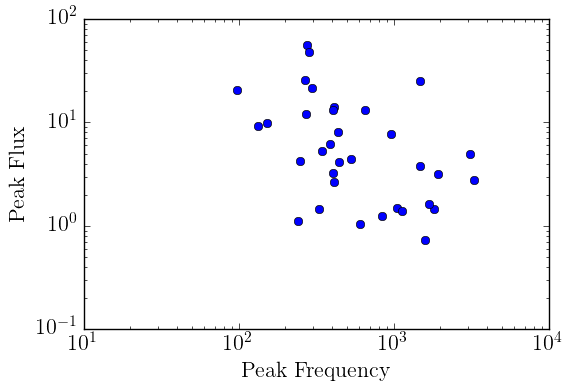

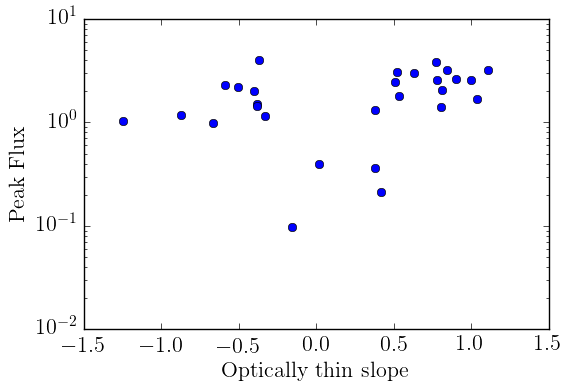

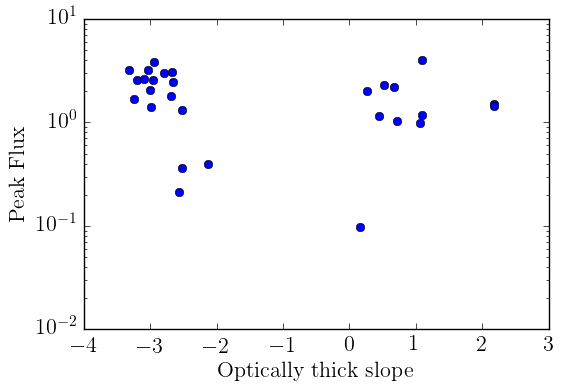

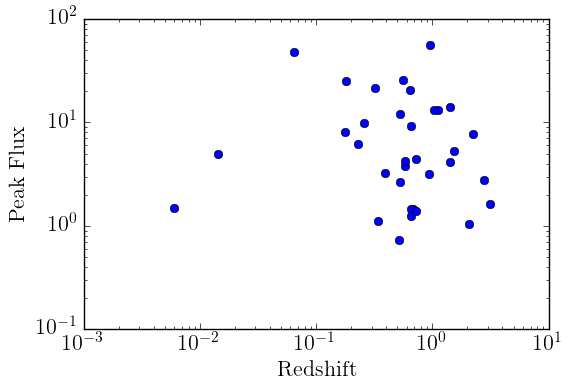

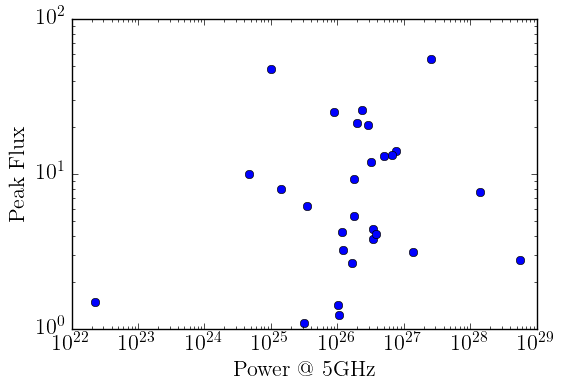

In [184]:
plt.loglog(matched_df.freq_1, matched_df.peak_1, 'o')
plt.ylabel('Peak Flux')
plt.xlabel('Peak Frequency')
plt.show()


plt.plot(matched_df.thin, np.log(matched_df.peak_1), 'o')
plt.ylabel('Peak Flux')
plt.yscale('log')
plt.xlabel('Optically thin slope')
plt.show()

plt.plot(matched_df.thick, np.log(matched_df.peak_1), 'o')
plt.ylabel('Peak Flux')
plt.yscale('log')
plt.xlabel('Optically thick slope')
plt.show()


plt.loglog(matched_df.z_2,matched_df.peak_1, 'o')
plt.ylabel('Peak Flux')
plt.xlabel('Redshift')
plt.show()

# peak flux, linear size


plt.loglog(matched_df.Power_5, matched_df.peak_1, 'o')
plt.ylabel('Peak Flux')
plt.xlabel('Power @ 5GHz')
plt.show()


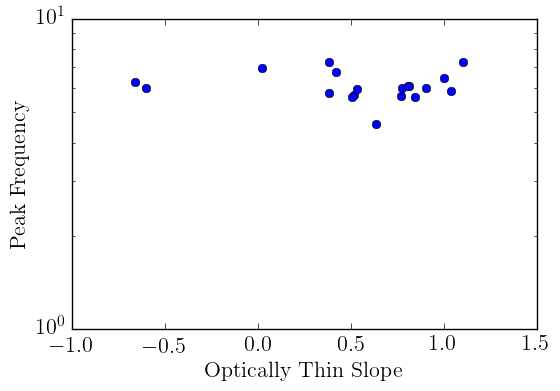

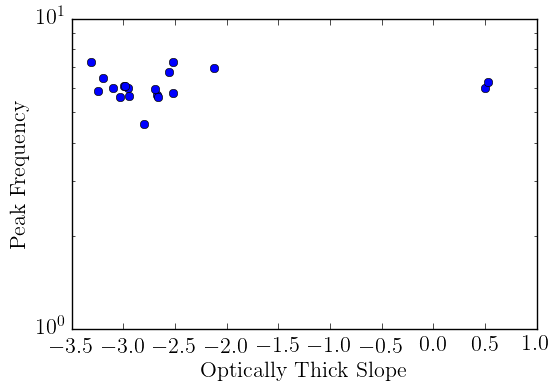

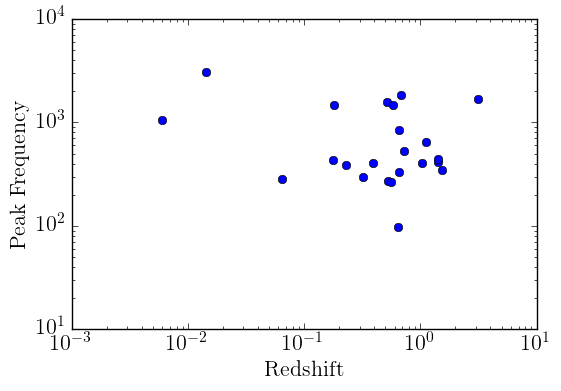

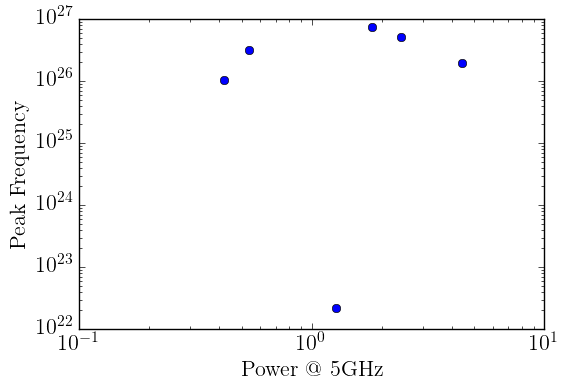

In [158]:

plt.plot(matched_df.thin,np.log(matched_df.freq_1),'o')
plt.ylabel('Peak Frequency')
plt.yscale('log')
plt.xlabel('Optically Thin Slope')
plt.show()

plt.plot(matched_df.thick,np.log(matched_df.freq_1),'o')
plt.ylabel('Peak Frequency')
plt.yscale('log')
plt.xlabel('Optically Thick Slope')
plt.show()

plt.loglog(matched_df.z_2,matched_df.freq_1,'o')
plt.ylabel('Peak Frequency')
plt.xlabel('Redshift')
plt.show()

plt.loglog(matched_df.s_5,matched_df.Power_5,'o')
plt.ylabel('Peak Frequency')
plt.xlabel('Power @ 5GHz')
plt.show()

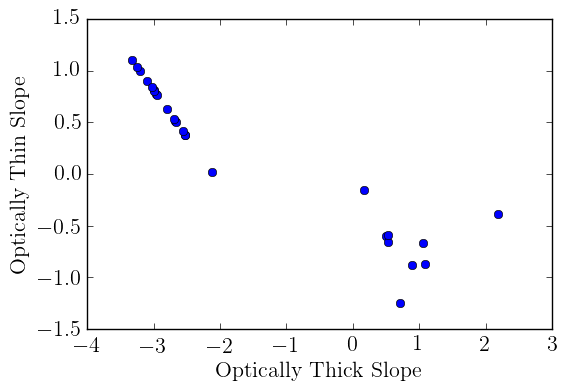

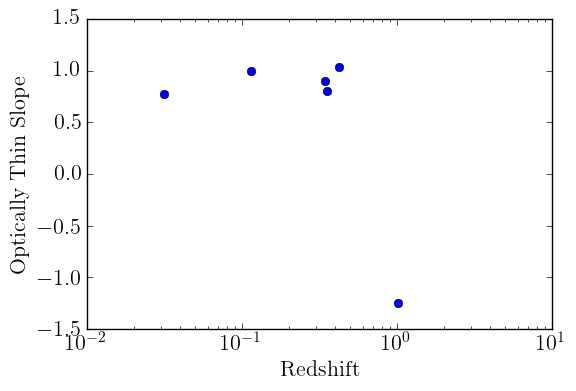

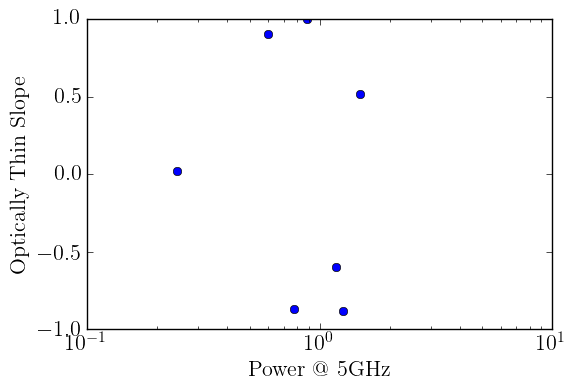

In [160]:
plt.plot(matched_df.thick, matched_df.thin,'o')
plt.xlabel('Optically Thick Slope')
plt.ylabel('Optically Thin Slope')
plt.show()

plt.plot(np.log(matched_df.z_2), matched_df.thin,'o')
plt.xlabel('Redshift')
plt.xscale('log')
plt.ylabel('Optically Thin Slope')
plt.show()

plt.plot(np.log(matched_df.s_5), matched_df.thin,'o')
plt.xlabel('Power @ 5GHz')
plt.xscale('log')
plt.ylabel('Optically Thin Slope')
plt.show()

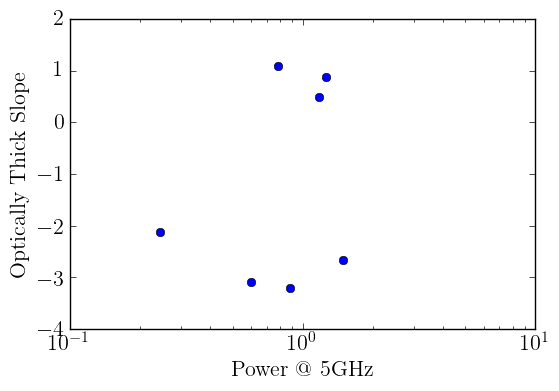

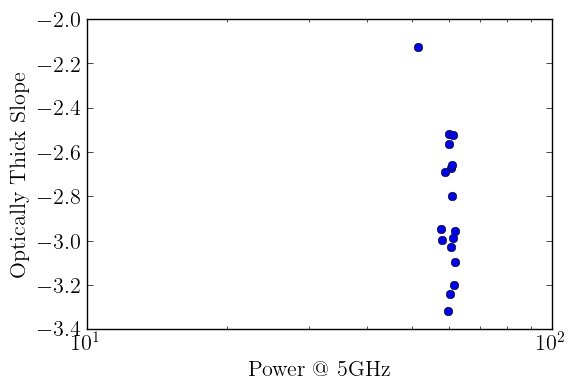

In [161]:
plt.plot(np.log(matched_df.s_5), matched_df.thick,'o')
plt.xlabel('Power @ 5GHz')
plt.xscale('log')
plt.ylabel('Optically Thick Slope')
plt.show()

plt.plot(np.log(matched_df.Power_5), matched_df.thick,'o')
plt.xlabel('Power @ 5GHz')
plt.xscale('log')
plt.ylabel('Optically Thick Slope')
plt.show()

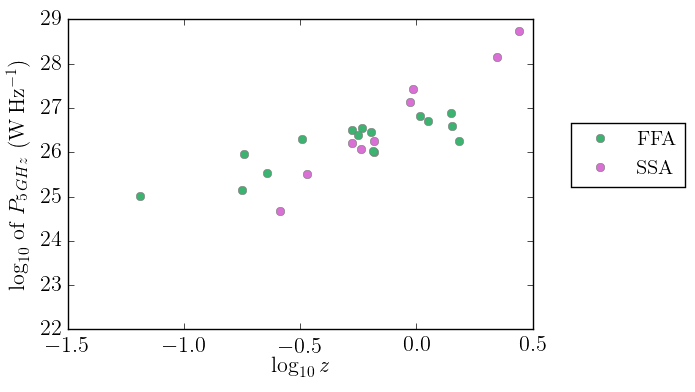

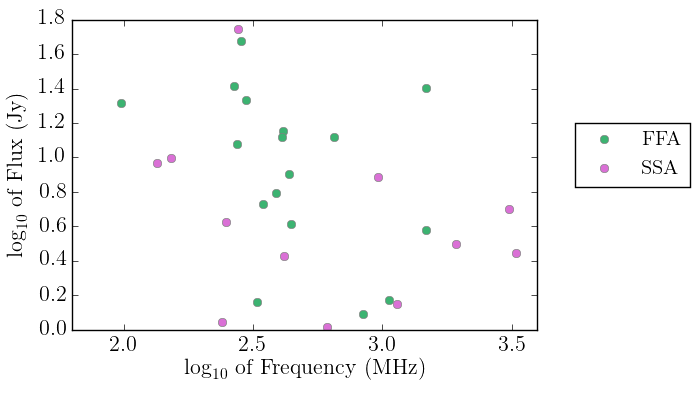

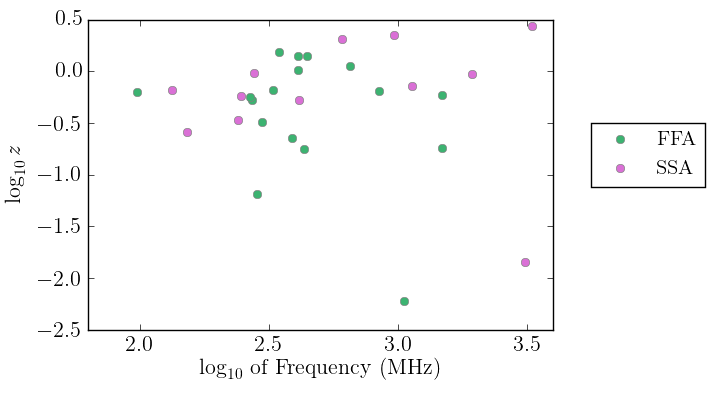

In [194]:
def pandas_is_stupid_plot(param1='z_2', param2='Power_5'):
    fig, ax = plt.subplots()
    for indx in matched_df.index.values:
        if mechdict[matched_df.loc[indx].model] == 'Neither':
            continue
        else:
            plt.plot(np.log10(matched_df.loc[indx][param1]),np.log10(matched_df.loc[indx][param2]), 'o', markeredgecolor='gray',
                       color=cdict_mech[mechdict[matched_df.loc[indx].model]], label=mechdict[matched_df.loc[indx].model])


    plt.xlabel(label_dict[param1])
    plt.ylabel(label_dict[param2])


    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    bbox = (1.35,0.7)
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=bbox, fontsize=15, numpoints=1)



pandas_is_stupid_plot(param1='z_2', param2='Power_5')
plt.xlim(-1.5, 0.5)
plt.show()


pandas_is_stupid_plot(param1='freq_1', param2='peak_1')
plt.show()

pandas_is_stupid_plot(param1='freq_1', param2='z_2')
plt.show()



In [188]:
label_dict={
    'z_2':'$\log_{10} z $', 'Power_5':r'$\log_{10}$ of $P_{\text{5\,GHz}}$ (W\,Hz$^{-1}$)', 'thick':'Optically Thick Slope', 'thin':'Optically Thin Slope',
    'freq_1': r'$\log_{10}$ of Frequency (MHz) ', 'peak_1':r'$\log_{10}$ of Flux (Jy) '
}

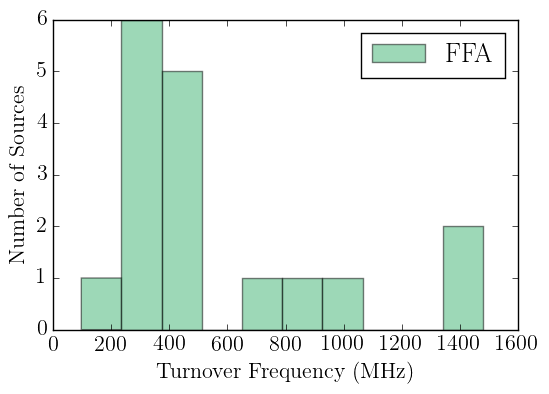

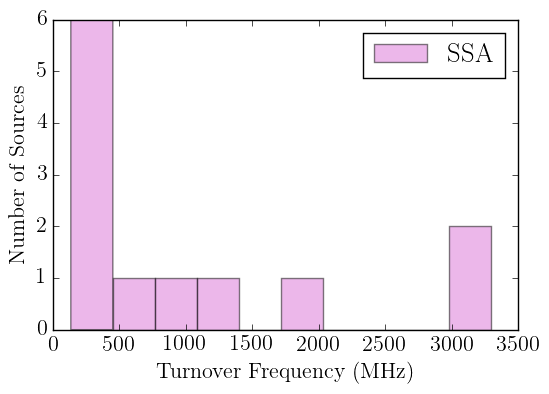

In [193]:
FFA_freqs = matched_df[matched_df['model'].apply(lambda x: mechdict[x]) == 'FFA'].freq_1.values
SSA_freqs = matched_df[matched_df['model'].apply(lambda x: mechdict[x]) == 'SSA'].freq_1.values

plt.hist(FFA_freqs, color='MediumSeaGreen', alpha = 0.5, label='FFA')

plt.legend()
plt.xlabel('Turnover Frequency (MHz)')
plt.ylabel('Number of Sources')
plt.show()

plt.hist(SSA_freqs, color='orchid', alpha = 0.5, label='SSA')
plt.legend()
plt.xlabel('Turnover Frequency (MHz)')
plt.ylabel('Number of Sources')
plt.show()

In [223]:
subset_df = matched_df[(matched_df['model'].apply(lambda x: mechdict[x]) == 'SSA')]
subset_df[subset_df['z_2'] < 0.6].name, subset_df[subset_df['z_2'] < 0.6].z_2

(22    j003830-2119
 25     pks1151-348
 26    j185958-6615
 27     pks1740-649
 31        4c-02.17
 Name: name, dtype: object, 22    0.338000
 25    0.258000
 26    0.580000
 27    0.014428
 31    0.530000
 Name: z_2, dtype: float64)

In [176]:
first_df[first_df['model'].apply(lambda x: mechdict[x]) == 'SSA']

,name,model,peak,freq,mechanism,thin,thick,z,ls,power
7,j221942-2756,doubSSAbreakexp,NaN,0,SSA,-0.503066,0.673523,NaN,NaN,NaN
9,j225053-1204,doubSSAbreakexp,NaN,0,SSA,-0.777060,0.498636,NaN,NaN,NaN
10,4c-06.76,doubSSAbreakexp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0743-673,doubSSAbreakexp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,j040820-6545,doubSSAbreakexp,NaN,0,SSA,-0.370131,NaN,NaN,NaN,NaN
16,0022-423,doubSSAbreakexp,NaN,0,SSA,-0.329026,0.451189,NaN,NaN,NaN
17,j011006-3651,doubSSAbreakexp,NaN,0,SSA,-0.255470,1.666715,NaN,NaN,NaN
20,pks0439-337,doubSSAbreakexp,NaN,0,SSA,-0.717649,0.450606,NaN,NaN,NaN
24,j024008-2309,doubSSAbreakexp,NaN,0,SSA,-0.400896,0.267229,NaN,NaN,NaN
30,j042408+0204,doubSSAbreakexp,NaN,0,SSA,NaN,NaN,NaN,NaN,NaN


In [ ]:
linsize_df = pd.read_csv('../survey_data/jey_match.csv')
linsize_dict = dict(zip(linsize_df['name_1a'],[''.join(l.lower().split(' ')) for l in linsize_df['ID']]))
rlinsize_dict = dict(zip([''.join(l.lower().split(' ')) for l in linsize_df['ID']], linsize_df['name_1a']))

In [ ]:
linsize_df['ID']=[''.join(l.lower().split(' ')) for l in linsize_df['ID']]
linsize_df.to_csv('../survey_data/jey_match.csv')

In [ ]:
jay_df = pd.DataFrame()
# S. Jeyakumar 2016 paper
texfiles = glob.glob('../survey_data/*.tex')
jey = []
for tex in texfiles: 
    try:
        tempdf = pd.read_csv(tex,
                         sep='&',
                         header=None,
                         engine='python', names = ['Source', 'Sample',  'ID', 'z', 'LAS', 'Vpeakc', 'Speak', 'LS', 'log(Lpeak)', 'Refd'])
        jay_df = tempdf.append(tempdf, ignore_index = True)
    except:
        pass
jay_df.drop_duplicates(inplace=True)
jay_df.Source = [''.join(name.lower().strip().split('$')) for name in jay_df.Source.tolist()]

In [ ]:
# match the subset of ATCA data with jay
temp = [(i,name) for (i,name) in zip(first_df.index.values,first_df.name.values) if name in linsize_dict.values()]
for i, name in temp: 
    try:
        foo = rlinsize_dict[name]
        z = float(jay_df[jay_df.Source == foo].z.values[0])
        las = float(jay_df[jay_df.Source == foo].LAS.values[0].split('$')[-1])
        ls = float(jay_df[jay_df.Source == foo].LS.values[0])
        first_df.set_value(i,'z', z)
        first_df.set_value(i,'las', las)
        first_df.set_value(i,'ls', ls)
    except:
        print(i,name)

In [ ]:
len(first_df)

In [ ]:
[jay_df[jay_df.Source == name].Source for name in  rlinsize_dict.values()]

In [ ]:
foo = rlinsize_dict['pks0941-080']
print(foo)
jay_df[jay_df.Source == foo]

In [ ]:
linsize_dict

In [ ]:
jay_df.Source, foo

In [ ]:
temp

In [ ]:
# callingham et al 2017

In [ ]:
first_df

In [ ]:
lsvsfreq = list(zip(first_df[first_df.ls.notnull()].freq,first_df[first_df.ls.notnull()].ls))

In [ ]:
lsvsfreq

In [ ]:
first_df.to_csv('first.csv')

In [ ]:
argnames